# open and process textgrid annotation

- docs [here](https://pypi.org/project/praat-textgrids/), doesn't work
- docs [here](https://github.com/kylebgorman/textgrid), does work. Kyle Gorman is mother

In [1]:
# import sys

# sys.path.append('~/Library/Python/3.8/lib/python/site-packages')

In [2]:
import textgrid

# Read a TextGrid object from a file.
tg = textgrid.TextGrid.fromFile('ATL.TextGrid')

In [3]:
# what textgrid object can do
print(*filter(lambda x: not x.startswith('_'), dir(tg[0])), sep='\n')

add
addInterval
bounds
fromFile
indexContaining
intervalContaining
intervals
maxTime
minTime
name
read
remove
removeInterval
strict
write


In [4]:
print(*filter(lambda x: not x.startswith('_'), dir(tg[0][0])), sep='\n')

bounds
duration
mark
maxTime
minTime
overlaps
strict


In [5]:
for tier in tg:
    print(tier.name, len(tier), sep='\t', end='\n')

word	1213
segment	1921
voice	1922
burst	612


In [6]:
tg[0][3].minTime

32.4882

## annotation manual


есть 4 слоя текст-грида:

 1. word — отмечаешь слово
 2. segment — сюда идут согласные, у которых в русском есть пара по глухости-звонкости.
- отмечать не как слышно, а как оно в русском слове — то есть, если консультант_ка говорит “вота” вместо “вода”, вносишь все равно “д”
- границами сегмента считается конец гласной/начало слова с одной стороны и начало следующей гласной/конец слова с другой
- граница с гласной — по первому циклу регулярного колебания, но хирургическая точность тут не очень важна, главное следующий слой
 3. voice — здесь отмечается, есть ли фонация (+) или ее нет (-). чаще всего тут можно будет просто скопировать интервал с предыдущего слоя и отметить +/-
 4. burst (точечный слой) — для взрывных отметить начало взрыва. этот момент должен всегда оказываться внутри интервала на слое segment, так как мы отмечаем от гласной/границы до гласной/границы

можно пропускать:

- согласные в кластерах — другой зверь, которого пока не трогаем (получается, отмечаем только контексты #_V, V_V, V_#)
- там, где консультант_ку перебивают, или речь очень тихая неразборчивая, шумная и тд, можно пропустить

## TODO

- составить таблицу по сегментам, каждый по отдельности
- колонки: segment (str), voiced (bool), context (List[initial, final, medial]), burst (bool), VOT, duration (float)

In [7]:
import numpy as np

In [122]:
initial_diffs = np.array([word.minTime - seg.minTime for seg, word in zip(tg[0], tg[1])])

In [123]:
words = [word for word in tg[0] if word.mark != '']
segments = [seg for seg in tg[1] if seg.mark != '']
voiced = [voi for voi in tg[2] if voi.mark != '']
bursts = tg[-1]

In [124]:
len(voiced)

960

In [125]:
len(segments)

960

In [126]:
'екст'.index('т') and 'екст'.count('т') == 1

True

In [127]:
import numpy as np

def get_context(seg, word):
    if word.mark.count(seg.mark) == 1:
        if word.mark.index(seg.mark) == 0:
            return 'initial'
        elif word.mark.index(seg.mark) == len(word.mark) - 1:
            return 'final'
        else:
            return 'medial'
    else:
        print(f'several {seg.mark} found in {word.mark}')
        if np.isclose(seg.minTime, word.minTime, 1e-3):
            return 'initial'
        elif np.isclose(seg.maxTime, word.maxTime, 1e-3):
            return 'final'
        else:
            return 'medial'
    
def get_vot(seg, burst):
    return seg.maxTime - burst.time

def get_segments(word, segments, tol=.8):
    res = []
    for seg in segments:
        intersection = (min(word.maxTime, seg.maxTime) - max(word.minTime, seg.maxTime)) / (seg.maxTime - seg.minTime + 1e-6)
        if intersection > tol or np.isclose(intersection, 0, 1e-3):
            res.append(seg)
    return res

def get_word(seg, words, tol=.8):
    for word in words:
        intersection = (min(word.maxTime, seg.maxTime) - max(word.minTime, seg.maxTime)) / (seg.maxTime - seg.minTime + 1e-6)
        if intersection > tol or np.isclose(intersection, 0, 1e-3):
            return word
        
def get_burst(seg, bursts):
    idx = np.argmin(np.array([abs(seg.minTime - burst.time) for burst in bursts]))
    return bursts[idx]

def get_voiced(seg, voiced, tol=.8):
    for voi in voiced:
        intersection = (min(voi.maxTime, seg.maxTime) - max(voi.minTime, seg.maxTime)) / (seg.maxTime - seg.minTime + 1e-6)
        if intersection > tol or np.isclose(intersection, 0, 1e-3):
            return voi

In [128]:
# колонки: segment (str), voiced (bool), context (List[initial, final, medial]), burst (bool), VOT, duration (float)
import pandas as pd

df_raw = pd.DataFrame({
    'segment': segments,
    'voiced': [get_voiced(seg, voiced) for seg in segments],
    'burst': [get_burst(seg, bursts) if seg.mark in ['б', 'п', 'т', 'д', 'к', 'г'] else None for seg in segments],
    'word': [get_word(seg, words) for seg in segments],
    'duration': [abs(seg.maxTime - seg.minTime) for seg in segments]
}).dropna(subset=['voiced', 'word'])

In [129]:
VOTs = []
contexts = []

for seg, burst in zip(df_raw.segment.values, df_raw.burst.values):
    if burst is None:
        VOTs.append(None)
    else:
        VOTs.append(get_vot(seg, burst))
        
for seg, word in zip(df_raw.segment.values, df_raw.word.values):
    contexts.append(get_context(seg, word))

several т found in тут-то
several т found in тут-то
several к found in как
several т found in интернате
several т found in работает
several т found in работает
several т found in воспитательница
several т found in воспитательница
several к found in канецкая
several с found in сестрам
several д found in да-да
several д found in да-да
several т found in тут
several т found in тут
several д found in дедушка
several д found in дедушка
several в found in звероводом
several в found in звероводом
several в found in верхнепуровский
several с found in таркосалинский
several с found in восемьдесят
several т found in детей-то
several т found in детей-то
several т found in тут
several т found in тут
several т found in тут
several т found in подметать
several т found in воспитательница
several т found in воспитательница
several т found in топить
several т found in топить
several т found in интернате
several т found in воспитательница
several т found in воспитательница
several с found in салехардски

In [130]:
df_raw['VOT'] = VOTs
df_raw['context'] = contexts

In [131]:
df_raw.head(1)

,segment,voiced,burst,word,duration,VOT,context
0,"Interval(31.61043, 31.71894, к)","Interval(31.61043, 31.71894, -)","Point(31.70536, None)","Interval(31.4817, 32.17194, акичевы)",0.10851,0.01358,medial


In [157]:
df = df_raw[['duration', 'VOT', 'context']]
df['word'] = df_raw['word'].apply(lambda x: x.mark)
df['segment'] = df_raw['segment'].apply(lambda x: x.mark)
df['voiced'] = df_raw['voiced'].apply(lambda x: None if x is None else x.mark).map({'-': False, '+': True})
df['burst'] = df_raw['burst'].apply(lambda x: x is not None)
df = df.drop(14)

<ipython-input-157-c91369182865>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word'] = df_raw['word'].apply(lambda x: x.mark)
<ipython-input-157-c91369182865>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['segment'] = df_raw['segment'].apply(lambda x: x.mark)
<ipython-input-157-c91369182865>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [158]:
df.head()

,duration,VOT,context,word,segment,voiced,burst
0,0.10851,0.01358,medial,акичевы,к,False,True
1,0.05661,NaN,medial,акичевы,в,True,False
2,0.03750,0.00737,medial,акичевы,к,False,True
3,0.08013,NaN,medial,акичевы,в,True,False
4,0.05456,0.01546,initial,тундровики,т,False,True


In [159]:
df.isna().sum()

duration      0
VOT         318
context       0
word          0
segment       0
voiced        0
burst         0
dtype: int64

In [160]:
df.context.value_counts()

medial     444
initial    442
final       47
Name: context, dtype: int64

In [161]:
df.to_csv('data/processed_ATL.csv')

## look at data

In [76]:
import pandas as pd

df = pd.concat([
    pd.read_csv('data/processed_ALK.csv', index_col='Unnamed: 0'),
    pd.read_csv('data/processed_ATL.csv', index_col='Unnamed: 0'),
]).reset_index(drop=True)

In [48]:
from scipy import stats

idx = np.all(np.abs(stats.zscore(df[['VOT', 'duration']], nan_policy='omit')) < 3, axis=1)

In [49]:
df.loc[idx].shape

(1465, 7)

In [50]:
df = df.loc[idx]

In [77]:
df.isna().sum()

duration      0
VOT         739
context       0
word          0
segment       0
voiced        0
burst         0
dtype: int64

In [52]:
df.context.value_counts()

initial    1161
medial      243
final        61
Name: context, dtype: int64

In [53]:
df.segment.value_counts()

т    502
д    319
п    211
к    210
б    140
г     83
Name: segment, dtype: int64

In [80]:
stop_df = df.loc[df.context == 'initial']\
    .groupby('segment')\
    .mean()[['duration', 'VOT', 'voiced']]\
    .round(3)\
    .dropna()\
    .loc[['п', 'б', 'т', 'д', 'к', 'г',]]

print(stop_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  duration &    VOT &  voiced \\
segment &           &        &         \\
\midrule
п       &     0.076 &  0.046 &   0.020 \\
б       &     0.084 &  0.019 &   0.230 \\
т       &     0.081 &  0.032 &   0.005 \\
д       &     0.079 &  0.042 &   0.522 \\
к       &     0.079 &  0.053 &   0.000 \\
г       &     0.078 & -0.006 &   0.388 \\
\bottomrule
\end{tabular}



<ipython-input-80-757c87d1c42a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stop_df = df.loc[df.context == 'initial']\
<ipython-input-80-757c87d1c42a>:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stop_df.to_latex())


In [78]:
fric_df = df.groupby('segment').mean()[['duration', 'VOT', 'voiced']].round(3).loc[['ф', 'в', 'ш', 'ж', 'с', 'з',]]
fric_df['count'] = df.segment.value_counts()[fric_df.index]
print(fric_df[['duration', 'voiced', 'count']].to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  duration &  voiced &  count \\
segment &           &         &        \\
\midrule
ф       &     0.096 &   0.000 &     10 \\
в       &     0.077 &   0.954 &    219 \\
ш       &     0.122 &   0.000 &     69 \\
ж       &     0.103 &   0.083 &    168 \\
с       &     0.105 &   0.006 &    166 \\
з       &     0.113 &   0.140 &    107 \\
\bottomrule
\end{tabular}



<ipython-input-78-6fb50fd1140d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fric_df = df.groupby('segment').mean()[['duration', 'VOT', 'voiced']].round(3).loc[['ф', 'в', 'ш', 'ж', 'с', 'з',]]
<ipython-input-78-6fb50fd1140d>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fric_df[['duration', 'voiced', 'count']].to_latex())


## compare with observed distributions for Russian

In [56]:
import scipy.stats as sps

In [57]:
df

,duration,VOT,context,word,segment,voiced,burst
0,0.05291,0.01873,initial,да,д,True,True
1,0.08954,0.01482,medial,рода,д,False,True
2,0.11897,0.02550,initial,та,т,False,True
4,0.09797,0.04897,initial,была,б,False,True
5,0.07025,0.01874,medial,хантыйка,к,False,True
...,...,...,...,...,...,...,...
2237,0.10366,0.01890,initial,пять,п,False,True
2238,0.20180,0.09079,medial,один,д,True,True
2239,0.08569,0.02960,initial,да,д,False,True
2243,0.15847,0.04363,initial,полы,п,False,True


In [88]:
df.loc[~df.voiced]

,duration,VOT,context,word,segment,voiced,burst
822,0.08414,NaN,initial,женщина,ж,False,False
523,0.05796,NaN,initial,замуж,з,False,False
1809,0.13383,0.06864,medial,родители,т,False,True
1721,0.12105,0.03471,medial,сушите,т,False,True
1210,0.07233,0.02442,initial,перед,п,False,True
1785,0.14242,NaN,initial,семьям,с,False,False
1930,0.08595,0.02788,initial,перевести,п,False,True
1185,0.08266,0.05780,initial,показать,п,False,True
979,0.13285,NaN,initial,жить,ж,False,False
1496,0.06138,0.02592,initial,потом,п,False,True


In [86]:
print(df.context.value_counts().to_latex())

\begin{tabular}{lr}
\toprule
{} &  context \\
\midrule
initial &     1670 \\
medial  &      489 \\
final   &       88 \\
\bottomrule
\end{tabular}



<ipython-input-86-5a712c10e110>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.context.value_counts().to_latex())


In [81]:
vots = df.groupby('segment').describe()['VOT'][['count', 'mean', 'std']].round(3).loc[['п', 'б', 'т', 'д', 'к', 'г',]]
vots['count'] = vots['count'].astype(int)
print(vots.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  count &   mean &    std \\
segment &        &        &        \\
\midrule
п       &    212 &  0.045 &  0.121 \\
б       &    141 &  0.022 &  0.116 \\
т       &    525 &  0.033 &  0.217 \\
д       &    327 &  0.040 &  0.212 \\
к       &    217 &  0.055 &  0.299 \\
г       &     86 & -0.015 &  0.294 \\
\bottomrule
\end{tabular}



<ipython-input-81-24048ab87a9c>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vots.to_latex())


In [83]:
print(vots[['count']].sort_values('count', ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
{} &  count \\
segment &        \\
\midrule
т       &    525 \\
д       &    327 \\
к       &    217 \\
п       &    212 \\
б       &    141 \\
г       &     86 \\
\bottomrule
\end{tabular}



<ipython-input-83-20d48ee78c99>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vots[['count']].sort_values('count', ascending=False).to_latex())


In [66]:
# initial stops only
obs_vot = pd.read_csv('obs_stops.csv', sep='\t', index_col='segment') / 1000
obs_vot['n_obs'] = [20*2*14 // 3, 23*2*14 // 3] * 3 # have to approximate n_obs
obs_vot

,mean,std,n_obs
segment,,,
п,0.018,0.008,186
б,-0.070,0.029,214
т,0.020,0.006,186
д,-0.075,0.029,214
к,0.038,0.012,186
г,-0.078,0.026,214


In [67]:
print(vots.to_latex(index=False))

\begin{tabular}{rrr}
\toprule
 count &  mean &   std \\
   211 & 0.038 & 0.057 \\
\midrule
   140 & 0.030 & 0.070 \\
   502 & 0.046 & 0.086 \\
   319 & 0.044 & 0.081 \\
   210 & 0.054 & 0.079 \\
    83 & 0.028 & 0.066 \\
\bottomrule
\end{tabular}



<ipython-input-67-5d243e59aa06>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vots.to_latex(index=False))


In [68]:
res = []

for seg in stop_df.index:
    subset = df.loc[(df.segment == seg) & (df.context == 'initial'), 'VOT']
    mean = subset.mean()
    std = subset.std()
    n_obs = subset.shape[0]
    test_res = sps.ttest_ind_from_stats(mean, std, n_obs,
                             obs_vot.loc[seg, 'mean'],
                             obs_vot.loc[seg, 'std'],
                             obs_vot.loc[seg, 'n_obs'],
                             )
    print(seg, '=========================', sep='\n')
    print(round((mean - obs_vot.loc[seg, 'mean']) * 1000, 1)) 
    print(test_res)
    if test_res.pvalue < 0.05:
        print('SIGNIFICANT')
    print('\n\n')
    res.append({
        'segment': seg,
        'mean_obs': round(mean * 1000, 1), 
        'mean_exp': round(obs_vot.loc[seg, 'mean']* 1000, 1), 
        'p': round(test_res.pvalue, 5), 
        'significant': 'yes' if test_res.pvalue < 0.05 else 'no', 
    })

п
19.7
Ttest_indResult(statistic=4.520763960317872, pvalue=8.237155300074708e-06)
SIGNIFICANT



б
97.7
Ttest_indResult(statistic=17.19856286320086, pvalue=6.893161078602056e-48)
SIGNIFICANT



т
21.6
Ttest_indResult(statistic=3.559396941047494, pvalue=0.0004033909898884233)
SIGNIFICANT



д
114.4
Ttest_indResult(statistic=20.31004087052516, pvalue=7.308058803903097e-66)
SIGNIFICANT



к
13.6
Ttest_indResult(statistic=2.182380671329948, pvalue=0.029763357877723797)
SIGNIFICANT



г
103.9
Ttest_indResult(statistic=17.52425887518042, pvalue=7.859385048371351e-47)
SIGNIFICANT





In [69]:
print(pd.DataFrame(res).to_latex(index=False))

\begin{tabular}{lrrrl}
\toprule
segment &  mean\_obs &  mean\_exp &       p & significant \\
\midrule
      п &      37.7 &      18.0 & 0.00001 &         yes \\
      б &      27.7 &     -70.0 & 0.00000 &         yes \\
      т &      41.6 &      20.0 & 0.00040 &         yes \\
      д &      39.4 &     -75.0 & 0.00000 &         yes \\
      к &      51.6 &      38.0 & 0.02976 &         yes \\
      г &      25.9 &     -78.0 & 0.00000 &         yes \\
\bottomrule
\end{tabular}



<ipython-input-69-c23e3ee0867c>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res).to_latex(index=False))


In [70]:
df.loc[df.context == 'final'].segment.value_counts()

т    39
к    12
д     9
г     1
Name: segment, dtype: int64

In [71]:
df.loc[df.context == 'medial'].segment.value_counts()

т    89
д    64
к    41
б    19
г    16
п    14
Name: segment, dtype: int64

Now we neutralise the laryngeal opposition

In [72]:
neutralise_voice = {
    'п': 'п',
    'б': 'п',
    'т': 'т',
    'д': 'т',
    'к': 'к',
    'г': 'к',
}

res = []

for seg in stop_df.index:
    subset = df.loc[(df.segment == seg) & (df.context == 'initial'), 'VOT']
    mean = subset.mean()
    std = subset.std()
    n_obs = subset.shape[0]
    ###
    map_seg = neutralise_voice[seg]
    ###
    test_res = sps.ttest_ind_from_stats(mean, std, n_obs,
                             obs_vot.loc[map_seg, 'mean'],
                             obs_vot.loc[map_seg, 'std'],
                             obs_vot.loc[map_seg, 'n_obs'],
                             alternative='two-sided'
                             )
    print(seg, '=========================', sep='\n')
    print(round((mean - obs_vot.loc[seg, 'mean']) * 1000, 1)) 
    print(test_res)
    if test_res.pvalue < 0.05:
        print('SIGNIFICANT')
    print('\n\n')
    
    res.append({
        'segment': seg,
        'mean_obs': round(mean * 1000, 1), 
        'mean_exp': round(obs_vot.loc[map_seg, 'mean']* 1000, 1), 
        'p': round(test_res.pvalue, 5), 
        'significant': 'yes' if test_res.pvalue < 0.05 else 'no', 
        'nobs': n_obs
    })
    
print(pd.DataFrame(res).to_latex(index=False))

п
19.7
Ttest_indResult(statistic=4.520763960317872, pvalue=8.237155300074708e-06)
SIGNIFICANT



б
97.7
Ttest_indResult(statistic=1.7823118121037522, pvalue=0.07569307814955548)



т
21.6
Ttest_indResult(statistic=3.559396941047494, pvalue=0.0004033909898884233)
SIGNIFICANT



д
114.4
Ttest_indResult(statistic=3.388854244784011, pvalue=0.0007665574975494305)
SIGNIFICANT



к
13.6
Ttest_indResult(statistic=2.182380671329948, pvalue=0.029763357877723797)
SIGNIFICANT



г
103.9
Ttest_indResult(statistic=-2.188967266036443, pvalue=0.0295244580999751)
SIGNIFICANT



\begin{tabular}{lrrrlr}
\toprule
segment &  mean\_obs &  mean\_exp &       p & significant &  nobs \\
\midrule
      п &      37.7 &      18.0 & 0.00001 &         yes &   197 \\
      б &      27.7 &      18.0 & 0.07569 &          no &   121 \\
      т &      41.6 &      20.0 & 0.00040 &         yes &   374 \\
      д &      39.4 &      20.0 & 0.00077 &         yes &   246 \\
      к &      51.6 &      38.0 & 0.02976 &         y

<ipython-input-72-2236d497afc8>:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res).to_latex(index=False))


In [73]:
df.segment.value_counts()

т    502
д    319
п    211
к    210
б    140
г     83
Name: segment, dtype: int64

In [74]:
voice_pairs = [
    ('п', 'б'),
    ('т', 'д'),
    ('к', 'г'),
]

res = []

for seg1, seg2 in voice_pairs:
    subset1 = df.loc[df.segment == seg1, 'VOT']
    mean1 = subset1.mean()
    std1 = subset1.std()
    n_obs1 = subset1.shape[0]

    subset2 = df.loc[df.segment == seg2, 'VOT']
    mean2 = subset2.mean()
    std2 = subset2.std()
    n_obs2 = subset2.shape[0]

    test_res = sps.ttest_ind_from_stats(
        mean1, std1, n_obs1,
        mean2, std2, n_obs2,
    )
    
    print(f'{seg1} vs {seg2}', '=========================', sep='\n')
    print(round((mean1 - mean2) * 1000, 1))
    print(test_res)
    if test_res.pvalue < 0.05:
        print('SIGNIFICANT')
    print('\n\n')
    
    res.append({
        'segment': f'{seg1} vs {seg2}',
        'mean_obs': round(mean1 * 1000, 1), 
        'mean_exp': round(mean2 * 1000, 1), 
        'p': round(test_res.pvalue, 5), 
        'significant': 'yes' if test_res.pvalue < 0.05 else 'no', 
    })
    
print(pd.DataFrame(res).to_latex(index=False))

п vs б
7.3
Ttest_indResult(statistic=1.073604152513926, pvalue=0.2837418782440269)



т vs д
2.1
Ttest_indResult(statistic=0.35572770406850296, pvalue=0.7221360985220393)



к vs г
26.1
Ttest_indResult(statistic=2.659769162407239, pvalue=0.008252818454228797)
SIGNIFICANT



\begin{tabular}{lrrrl}
\toprule
segment &  mean\_obs &  mean\_exp &       p & significant \\
\midrule
 п vs б &      37.6 &      30.2 & 0.28374 &          no \\
 т vs д &      45.7 &      43.6 & 0.72214 &          no \\
 к vs г &      54.2 &      28.2 & 0.00825 &         yes \\
\bottomrule
\end{tabular}



<ipython-input-74-0bd2e5a4a38b>:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res).to_latex(index=False))


In [75]:
res = []

for seg in stop_df.index:
    subset1 = df.loc[(df.segment == seg) & (df.context == 'final'), 'VOT']
    mean1 = subset1.mean()
    std1 = subset1.std()
    n_obs1 = subset1.shape[0]

    subset2 = df.loc[(df.segment == seg) & (df.context != 'final'), 'VOT']
    mean2 = subset2.mean()
    std2 = subset2.std()
    n_obs2 = subset2.shape[0]
    
    print(seg, '=========================', sep='\n')
    
    try:
        test_res = sps.ttest_ind_from_stats(
            mean1, std1, n_obs1,
            mean2, std2, n_obs2,
        )
    except ZeroDivisionError:
        print('not enough observations', end='\n\n')
        continue

    print(round((mean1 - mean2) * 1000, 1)) 
    print(test_res)
    if test_res.pvalue < 0.05:
        print('SIGNIFICANT')
    print('\n\n')
    
    res.append({
        'segment': seg,
        'mean_obs': round(mean1 * 1000, 1), 
        'mean_exp': round(mean2 * 1000, 1), 
        'p': round(test_res.pvalue, 5), 
        'significant': 'да' if test_res.pvalue < 0.05 else 'нет', 
    })
    
print(pd.DataFrame(res).to_latex(index=False))

п
not enough observations

б
not enough observations

т
24.1
Ttest_indResult(statistic=1.6800232634779801, pvalue=0.09357742244465614)



д
-15.4
Ttest_indResult(statistic=-0.5652771787956233, pvalue=0.5722850932194199)



к
-4.7
Ttest_indResult(statistic=-0.20086286598083075, pvalue=0.8410020785989152)



г
-8.0
Ttest_indResult(statistic=nan, pvalue=nan)



\begin{tabular}{lrrrl}
\toprule
segment &  mean\_obs &  mean\_exp &       p & significant \\
\midrule
      т &      68.0 &      43.8 & 0.09358 &         нет \\
      д &      28.6 &      44.0 & 0.57229 &         нет \\
      к &      49.8 &      54.5 & 0.84100 &         нет \\
      г &      20.3 &      28.3 &     NaN &         нет \\
\bottomrule
\end{tabular}



<ipython-input-75-47fc9929524f>:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res).to_latex(index=False))


## contextual distribution of VOT

In [42]:
df.describe()

,duration,VOT
count,593.000000,593.000000
mean,0.103739,0.049599
std,0.033550,0.077291
min,0.037500,-0.559760
25%,0.079800,0.027580
50%,0.099440,0.039870
75%,0.121550,0.056490
max,0.213120,0.775760


<AxesSubplot:xlabel='context'>

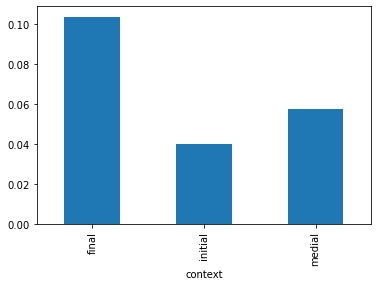

In [43]:
df.groupby('context').VOT.mean().plot(kind='bar')

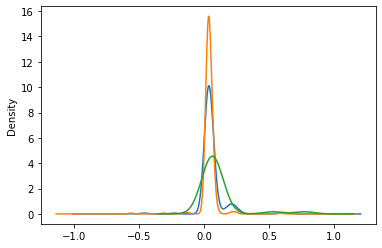

In [44]:
for context in df.context.unique():
    df.loc[df.context == context, 'VOT'].plot(kind='kde')

In [45]:
df.loc[(df.segment == 'в') & (~df.voiced)]

,duration,VOT,context,word,segment,voiced,burst


In [46]:
df.loc[(df.segment == 'в') & (df.voiced), 'context'].value_counts()

Series([], Name: context, dtype: int64)